In [29]:
import pandas as pd
from datetime import datetime
import shapefile
import csv
import numpy as np
from __future__ import division
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from patsy import dmatrices

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import pickle

import time
from pylab import *

### Define helper functions

In [26]:
def make_age(text):
    """Given a year in string format, return current age"""
    
    return 2015 - datetime.strptime(text, '%Y').year

# for reading csv: converters = {13:make_age}, but NA values mess it up

def explore(x, dataset_name):
    """Print specified summary information of given dataset x"""
    
    d = {}
    d['length'] = len(x)
    d['unique neighborhoods'] = len(x.n1.value_counts())
    d['unique stations'] = len(x.start_station_id.value_counts())
    d['percent of start stations in Manhattan'] = "{0:.3%}".format(x.b1.value_counts()[0]/len(x))
    d['percent of end stations in Manhattan'] = "{0:.3%}".format(x.b2.value_counts()[0]/len(x))
    d['percent of trips under 45min'] = "{0:.3%}".format(x.over_45.value_counts()[0]/len(x))
    d['most popular start station'] = "{0}".format(x.n1.value_counts().reset_index().ix[0].tolist())
    d['least popular start station'] = "{0}".format(x.n1.value_counts().reset_index().ix[36].tolist())
    d['unique bikes'] = len(x.bikeid.unique())
    d['percent subscribers'] = "{0:.3%}".format(x.usertype.value_counts()[0]/len(x))
    
    if x.birth_year.isnull().any() == False:
        d['mean birth year'] = "{0:.0f}".format(x.birth_year.mean())
    
    print "\nSummary of {0} dataset".format(dataset_name), pd.DataFrame(d.items())

### Read files to dataframes

In [3]:
data_hoods = pd.read_csv('nyc_neighborhoods_copy.csv') # merged database from CartoDB
docks = data_hoods[['id','docks']] # create sub dataframe of dock capacity per id

df_1 = pd.read_csv('citibike_jan.csv') # merged database of neighborhoods and citibike data
df_2 = pd.read_csv('citibike_feb.csv') # merged database of neighborhoods and citibike data
df_12 = pd.read_csv('citibike_dec.csv') # merged database of neighborhoods and citibike data

### Create one dataframe of multiple months

In [22]:
full_df = pd.concat([df_12,df_1,df_2])

In [46]:
print len(df_1)
print len(df_2)
print len(df_12)

284014
196008
396763


In [77]:
len(full_df)

876785

### Add fields

In [23]:
# Prepare datasets for analysis (add variables, merge dock info)

# Create continuous time variable in min, from 0 (12am) to 1439 (11:59pm)
full_df['starttime_time'] = full_df['starttime'].map(lambda x: time.strptime(x, "%Y-%m-%d %H:%M:%S").tm_hour*60 + 
                                      time.strptime(x, "%Y-%m-%d %H:%M:%S").tm_min)

# create 'over_45' min column (1 if yes, 0 if no) -- for exploration purposes
full_df['over_45'] = full_df.tripduration.map(lambda x: 1 if x>2700 else 0)

week   = ['Monday', 'Tuesday', 'Wednesday', 
              'Thursday', 'Friday', 'Saturday','Sunday']

# Column for day of the week (0-6)
full_df['day_start']=full_df['starttime'].map(lambda x: week[datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday()])

# merge!
t = pd.merge(full_df,docks,how='left',left_on='start_station_id',right_on='id')
full_df = pd.merge(t,docks,how='left',left_on='end_station_id',right_on='id')

### Dump dataframe into pickle file

In [79]:
with open('full_data.pkl','wb') as f:
    pickle.dump(full_df,f)

### Explore the data

In [24]:
# Subset for subscribers, and trips over 1hr

df_sub = full_df[(full_df['birth_year']>1915.0) & (full_df['usertype']=='Subscriber') 
                 & (full_df['gender']!=0) & (full_df['tripduration']<=3600)] 

In [27]:
explore(full_df,'full')
explore(df_sub,'sub')


Summary of full dataset                                         0                     1
0            percent of trips under 45min               99.153%
1              most popular start station   ['Chelsea', 129565]
2                         unique stations                   329
3                                  length                876785
4    percent of end stations in Manhattan               93.719%
5                            unique bikes                  5445
6             least popular start station  ['Columbia St', 304]
7  percent of start stations in Manhattan               93.629%
8                     percent subscribers               97.234%
9                    unique neighborhoods                    37

Summary of sub dataset                                          0                     1
0             percent of trips under 45min               99.753%
1               most popular start station   ['Chelsea', 126824]
2                          unique stations          

### Distribution of birth years

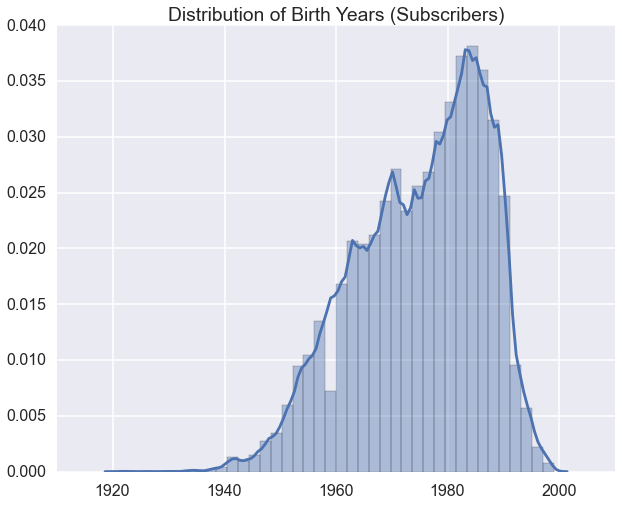

In [30]:
plt.figure(figsize=(10, 8))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.distplot(df_sub.birth_year.values,bins=40)
plt.title("Distribution of Birth Years (Subscribers)")
savefig('age_dist.png')

### Distribution of dock capacities over 329 stations

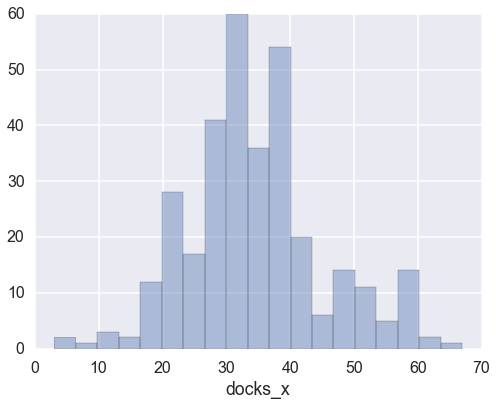

In [171]:
g = df_sub.groupby('id_x')

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.distplot(g.docks_x.mean(),kde=False)

In [12]:
print "Stations with highest dock capacity"
print data_hoods.sort('docks',ascending=False)[['id','docks','address']].head()
print "\nStations with lowest dock capacity"
print data_hoods.sort('docks',ascending=False)[['id','docks','address']].tail()

Stations with highest dock capacity
      id  docks                            address
170  521     67                    8 Ave & W 31 St
37    83     62      Atlantic Ave & Fort Greene Pl
276  519     61                  Pershing Square N
64   281     59  Grand Army Plaza & Central Park S
205  427     59                           State St

Stations with lowest dock capacity
      id  docks                        address
328  532     10                S 5 Pl & S 4 St
92   524      7                W 43 St & 6 Ave
25   253      7                W 13 St & 5 Ave
211  297      3                E 15 St & 3 Ave
186  321      3  Cadman Plaza E & Red Cross Pl


### Distribution of gender for all rides

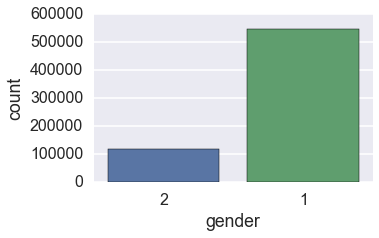

In [172]:
plt.figure(figsize=(5, 3))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.countplot(df_sub.gender)

### Number of trips by time of day (starttime_time in minutes from 00:00)

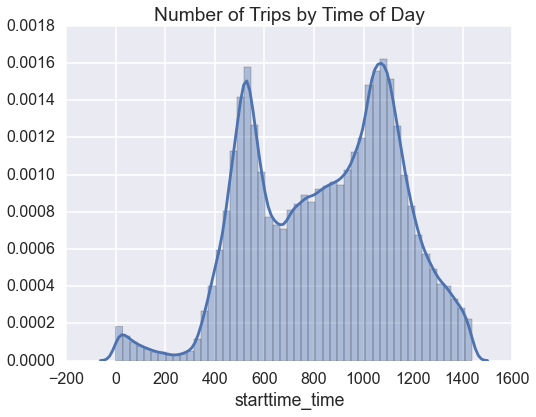

In [31]:
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.distplot(df_sub.starttime_time)
plt.title("Number of Trips by Time of Day")
savefig('trips_by_hour.png')

### Mean trip duration per hour

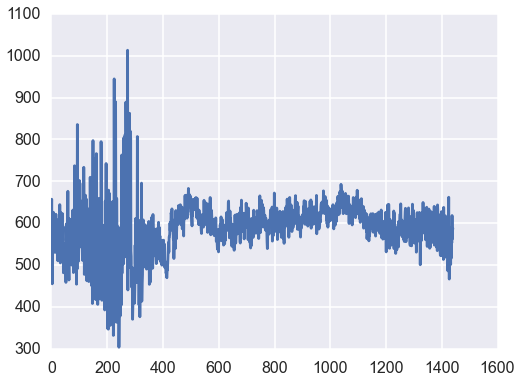

In [174]:
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
a = df_sub.groupby('starttime_time')
plt.plot(a.tripduration.mean())

### Trip duration distribution

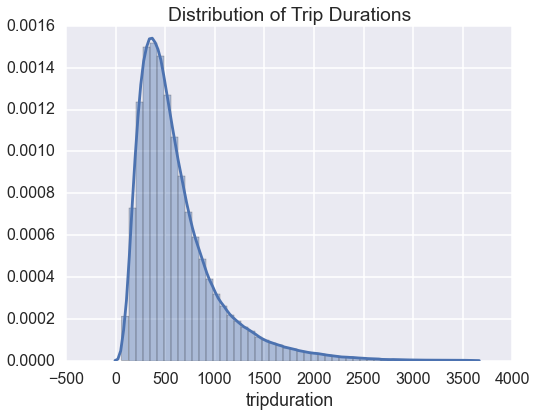

In [32]:
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.distplot(df_sub.tripduration)
plt.title("Distribution of Trip Durations")
savefig('trip_dist.png')

### Average trip duration from neighborhoods

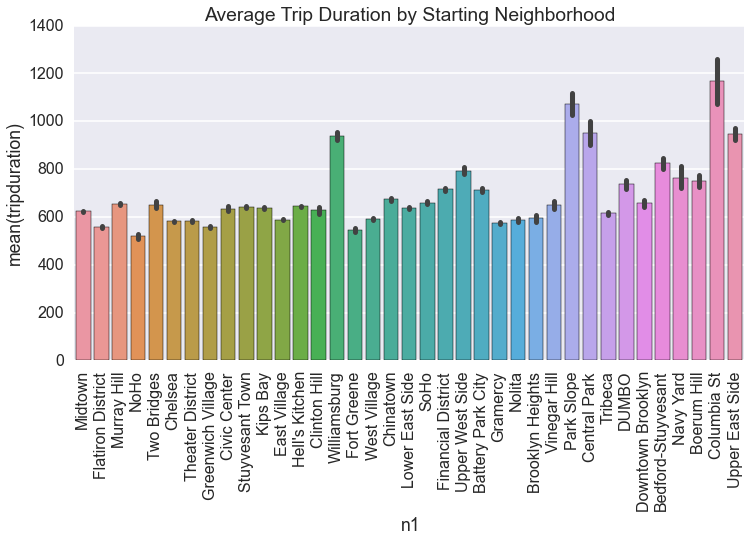

In [34]:
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
a = df_sub.groupby('n1')
names = a.tripduration.mean().reset_index()['n1']
y = a.tripduration.mean().reset_index()['tripduration']

sns.barplot(x = 'n1', y = 'tripduration', data = df_sub, estimator = np.mean)
plt.xticks(rotation='90')
plt.title("Average Trip Duration by Starting Neighborhood")
#plt.bar(range(len(names)),y)
#plt.xticks(range(len(names)), names, rotation='90')
plt.show()
savefig('avg_trip_neighborhood.png')

### Average trip duration by borough start station

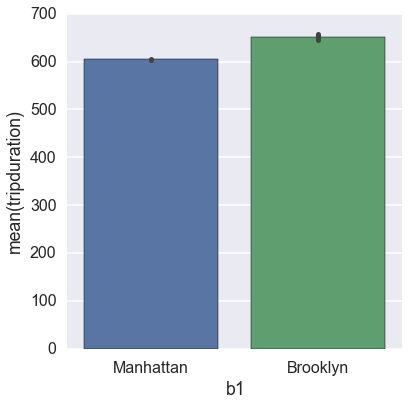

In [185]:
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
#a = df_sub.groupby('b1')
#names = a.tripduration.mean().reset_index()['b1']
#y = a.tripduration.mean().reset_index()['tripduration']

sns.barplot(x = 'b1', y = 'tripduration', data = df_sub, estimator = np.mean)

#plt.bar(range(len(names)),y)
#plt.xticks(range(len(names)), names)
plt.show()

In [186]:
# list most frequented destination station given start station
g = df_sub.groupby('n1')
s = []
for n in df_sub['n1'].unique():
    print n,g.n2.value_counts().xs(n).reset_index().ix[0].values
    s.append(g.n2.value_counts().xs(n).reset_index().ix[0].values)

Chelsea ['Chelsea' 34951]
Gramercy ['Chelsea' 4224]
Midtown ['Midtown' 29026]
SoHo ['West Village' 2189]
Downtown Brooklyn ['Fort Greene' 1199]
Bedford-Stuyvesant ['Bedford-Stuyvesant' 644]
East Village ['East Village' 20125]
Greenwich Village ['East Village' 5959]
West Village ['Chelsea' 7557]
Theater District ['Midtown' 7827]
Hell's Kitchen ['Midtown' 9987]
Kips Bay ['Midtown' 5425]
Lower East Side ['Lower East Side' 8673]
Nolita ['East Village' 2456]
Stuyvesant Town ['East Village' 2669]
Flatiron District ['Chelsea' 4182]
Battery Park City ['Battery Park City' 2249]
Fort Greene ['Fort Greene' 4991]
Williamsburg ['Williamsburg' 1446]
Financial District ['Financial District' 4602]
Vinegar Hill ['Fort Greene' 471]
Tribeca ['Tribeca' 4625]
Upper East Side ['Midtown' 529]
Upper West Side ['Midtown' 1454]
Murray Hill ['Midtown' 5979]
Brooklyn Heights ['Brooklyn Heights' 1820]
Clinton Hill ['Fort Greene' 2010]
Chinatown ['Lower East Side' 3329]
DUMBO ['Brooklyn Heights' 436]
Park Slope ['B

In [20]:
# plot top dest stations (not telling)

plt.figure(figsize=(10, 8))
sns.set_style("darkgrid")
sns.set_context(context="poster")

g = pd.DataFrame(s).groupby(0)
d = g.sum().reset_index().sort(1,ascending=False)
n = d[0].values
ct = d[1].values
#plt.bar(range(len(n)),ct,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("dark", 10))
#plt.xticks(range(len(n)), n, rotation='90')

### Create time passed between trips, dataframe

In [56]:
df_bikeid = full_df.copy(deep=True) # make copy of original data

In [57]:
# convert time columns into datetime objects

df_bikeid['starttime'] = df_bikeid['starttime'].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
df_bikeid['stoptime'] = df_bikeid['stoptime'].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [58]:
# sort data by bikeid, then chronologically

df2_bikeid = df_bikeid.sort(columns = ['bikeid','starttime'],ascending=[0, 1]) # sort by bike, then time

In [60]:
# shift data down to append later on

t = df2_bikeid.shift(1)
t = t[['stoptime','end_station_id','bikeid']]
t.columns = [x+"_" for x in t.columns]

In [62]:
# append data

df_bikeid = pd.concat((t,df2_bikeid),1)

# keep rows where bikeids are equal

df_bikeid = df_bikeid[df_bikeid['bikeid_']==df_bikeid['bikeid']]

In [68]:
# create column of time lapsed
df_bikeid['time_lapsed'] = df_bikeid.apply(lambda row: (row['starttime'] 
                                                        - row['stoptime_']), axis=1)

In [69]:
# Boolean variable to measure equality of end and start stations
df_bikeid['same_station'] = df_bikeid.apply(lambda row: True if 
                    row['end_station_id_'] == row['start_station_id'] else False, axis=1)